# ピーターとオオカミ: リアルな環境

この状況では、ピーターはほとんど疲れたり空腹になったりせずに移動することができました。しかし、より現実的な世界では、時々座って休んだり、食事を取ったりする必要があります。以下のルールを実装して、私たちの世界をよりリアルにしてみましょう:

1. 一つの場所から別の場所へ移動することで、ピーターは**エネルギー**を失い、**疲労**を蓄積します。
2. ピーターはリンゴを食べることでエネルギーを回復できます。
3. ピーターは木の下や草の上で休むことで疲労を解消できます（つまり、木や草がある場所 - 緑のフィールドに移動する）。
4. ピーターはオオカミを見つけて倒す必要があります。
5. オオカミを倒すためには、ピーターは一定のエネルギーと疲労のレベルを持っている必要があり、そうでない場合は戦いに敗北します。


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

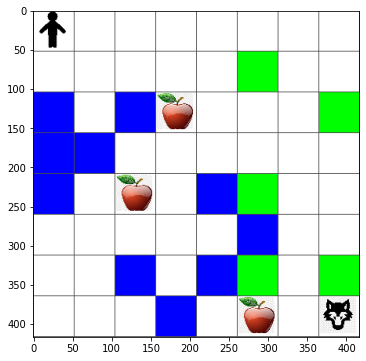

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## 状態の定義

新しいゲームルールでは、各ボード状態でエネルギーと疲労を追跡する必要があります。そのため、現在の問題状態に関するすべての必要な情報を保持するオブジェクト `state` を作成します。この情報には、ボードの状態、現在のエネルギーと疲労のレベル、そして終端状態でオオカミに勝てるかどうかが含まれます。


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

ランダムウォークを使用して問題を解決し、成功するかどうか試してみましょう:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## 報酬関数

### 概要
報酬関数は、エージェントが環境内でどのように行動するかを導く重要な要素です。適切に設計された報酬関数は、エージェントが望ましい目標を達成するための行動を学習するのを助けます。

### 目的
報酬関数の目的は、エージェントが特定のタスクを効率的かつ効果的に完了するように動機付けることです。これには、以下のような要素が含まれます:
- 目標達成を促進する
- 不適切な行動を抑制する
- 学習プロセスを加速する

### 設計のベストプラクティス
報酬関数を設計する際には、以下の点を考慮してください:
1. **明確な目標を設定する**  
   報酬関数は、エージェントが達成すべき目標を明確に反映する必要があります。

2. **バランスを取る**  
   報酬を与える基準が厳しすぎたり緩すぎたりすると、エージェントの学習が妨げられる可能性があります。

3. **負の報酬を慎重に使用する**  
   負の報酬は、エージェントが望ましくない行動を避けるのに役立ちますが、過度に使用すると学習が停滞する可能性があります。

4. **スパース報酬を避ける**  
   報酬が稀にしか与えられない場合、エージェントが目標に到達するための適切な行動を学ぶのが難しくなることがあります。

### 例
以下は、報酬関数の例です:

```python
def reward_function(params):
    # 車両がトラックの中央に近いほど高い報酬を与える
    if params['distance_from_center'] < params['track_width'] * 0.1:
        reward = 1.0
    else:
        reward = 0.5

    # 車両が進行方向に正しく向いている場合、追加の報酬を与える
    if params['is_heading_correct']:
        reward += 0.5

    return reward
```

### 注意事項
- 報酬関数が複雑すぎると、エージェントが学習するのに時間がかかる可能性があります。
- 報酬関数をテストして、エージェントが期待通りの行動を示すかどうかを確認してください。

### 結論
報酬関数は、エージェントの学習プロセスにおいて重要な役割を果たします。慎重に設計することで、エージェントが効率的に目標を達成できるようになります。


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learningアルゴリズム

実際の学習アルゴリズムはほとんど変わりません。ただし、単なる盤面の位置ではなく、`state`を使用します。


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

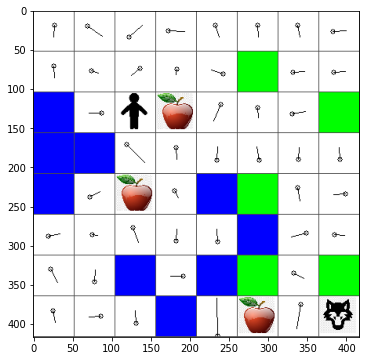

In [11]:
m.plot(Q)

## 結果

ピーターがオオカミと戦う訓練に成功したかどうか見てみましょう！


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


溺死のケースは今ではかなり減りましたが、ピーターはまだ必ずしもオオカミを殺すことができるわけではありません。ハイパーパラメータを調整して、この結果を改善できるか試してみてください。


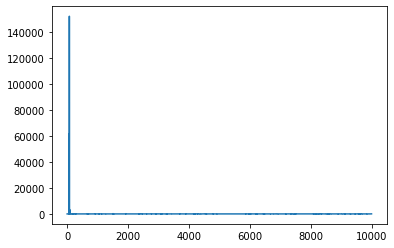

In [13]:
plt.plot(lpath)


---

**免責事項**:  
この文書は、AI翻訳サービス [Co-op Translator](https://github.com/Azure/co-op-translator) を使用して翻訳されています。正確性を追求しておりますが、自動翻訳には誤りや不正確な部分が含まれる可能性があることをご承知ください。元の言語で記載された文書が正式な情報源とみなされるべきです。重要な情報については、専門の人間による翻訳を推奨します。この翻訳の使用に起因する誤解や誤った解釈について、当方は責任を負いません。
